<a href="https://colab.research.google.com/github/PsorTheDoctor/computer-vision/blob/master/pose_estimation/yolo_nas_pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q super-gradients

In [ ]:
import json
import os
import random
from typing import List, Tuple, Union

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

yolo_nas_pose = models.get('yolo_nas_pose_l', pretrained_weights='coco_pose').cuda()

[2024-02-26 21:05:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


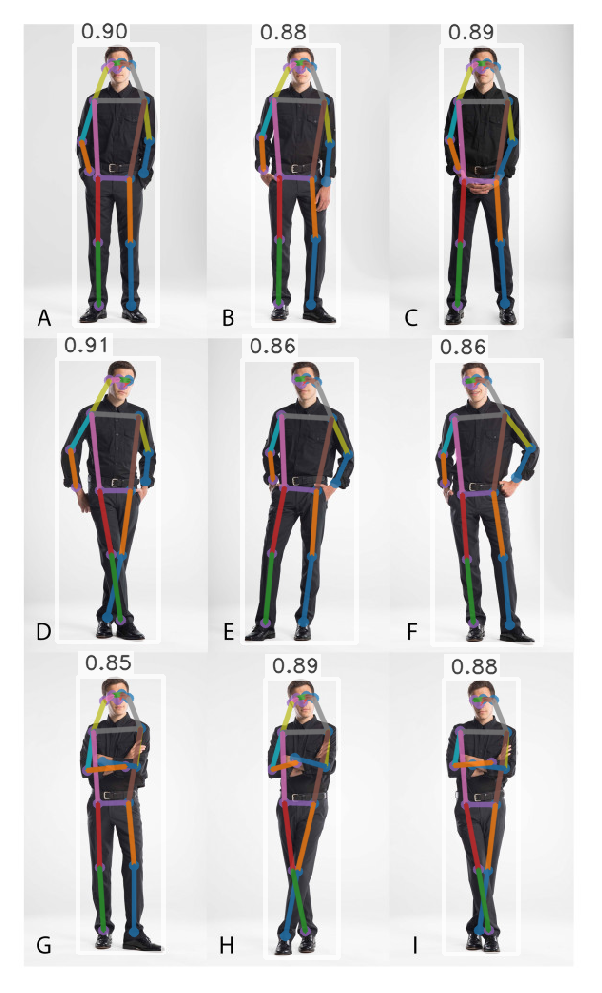

In [ ]:
url = 'https://rockynook.com/wp-content/uploads/2015/10/Male-Posing-Chart-612x1024.jpg'
yolo_nas_pose.predict(url, conf=0.7).show()

In [ ]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='first_yn_pose_run', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import locale
locale.getpreferredencoding = lambda: 'UTF-8'
!cp -r '/content/drive/MyDrive/tiger-dataset' '/content/'

In [ ]:
def open_file(file_path: str) -> Union[dict, list, None]:
    """
    Opens and reads the content of a JSON or YAML file.
    """
    try:
        with open(file_path, 'r') as file:
            if file_path.endswith('.json'):
                return json.load(file)
            elif file_path.endswith('.yaml') or file_path.endswith('.yml'):
                return yaml.safe_load(file)
            else:
                raise ValueError(f'Unsupported file format: {file_path}')
    except Exception as e:
        print(f'An error occurred: {e}')
        return None

annotations = open_file('/content/tiger-dataset/train/keypoint_train.json')
config = open_file('/content/tiger-dataset/tiger_coco_pose_estimation_dataset_params.yaml')

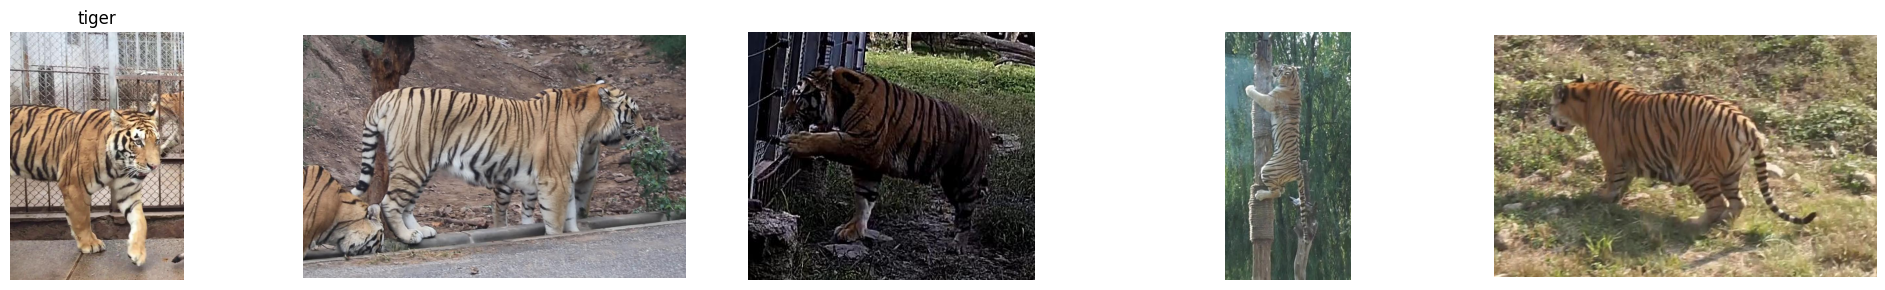

In [ ]:
def plot_random_images(data, image_base_dir="/content/images"):
    """
    Plots 5 random images for each category from the provided dataset.
    """
    # Create a dictionary to map image IDs to filenames
    image_id_to_filename = {image['id']: image['filename'] for image in data['images']}

    # Extracting image_ids for each category
    category_image_ids = {}
    for category in data['categories']:
        category_id = category['id']
        category_name = category['name']
        category_image_ids[category_name] = [anno['image_id'] for anno in data['annotations'] if anno['category_id'] == category_id]

    # Randomly select 5 image_ids for each category
    random_selected_ids = {}
    for category_name, ids in category_image_ids.items():
        random_selected_ids[category_name] = random.sample(ids, min(5, len(ids)))

    # Number of categories
    num_categories = len(random_selected_ids)

    # Create a figure to plot the images
    fig, axes = plt.subplots(num_categories, 5, figsize=(20, num_categories * 3))
    if num_categories == 1:  # If there is only one category, axes will be 1D
        axes = [axes]

    for i, (category_name, ids) in enumerate(random_selected_ids.items()):
        for j, image_id in enumerate(ids):
            # Get the filename using the image_id_to_filename dictionary
            filename = image_id_to_filename.get(image_id, "Image_Not_Found.jpg")

            # Load and plot the image
            img_path = os.path.join(image_base_dir, filename)
            try:
                img = mpimg.imread(img_path)
                axes[i][j].imshow(img)
            except FileNotFoundError:
                axes[i][j].imshow(np.zeros((100, 100, 3)))  # Show an empty image if file is not found
            axes[i][j].axis('off')
            if j == 0:
                axes[i][j].set_title(category_name)

    plt.tight_layout()
    plt.show()

plot_random_images(data=annotations, image_base_dir="/content/tiger-dataset/train")

##Dataloaders

In [ ]:
from super_gradients.common.decorators.factory_decorator import resolve_param
from super_gradients.common.factories.target_generator_factory import TargetGeneratorsFactory
from super_gradients.common.factories.transforms_factory import TransformsFactory
from super_gradients.common.object_names import Datasets
from super_gradients.common.registry import register_dataset
from super_gradients.training.transforms.keypoint_transforms import AbstractKeypointTransform
from super_gradients.training.samples import PoseEstimationSample
from super_gradients.training.datasets.pose_estimation_datasets.abstract_pose_estimation_dataset import AbstractPoseEstimationDataset
from super_gradients.training.datasets.pose_estimation_datasets import YoloNASPoseCollateFN

class PoseEstimationDataset(AbstractPoseEstimationDataset):
    """
    Dataset class for training pose estimation models on Animal Pose dataset.
    """
    @resolve_param("transforms", TransformsFactory())
    def __init__(
        self,
        data_dir: str,
        images_dir: str,
        json_file: str,
        transforms: List[AbstractKeypointTransform],
        edge_links: Union[List[Tuple[int, int]], np.ndarray],
        edge_colors: Union[List[Tuple[int, int, int]], np.ndarray, None],
        keypoint_colors: Union[List[Tuple[int, int, int]], np.ndarray, None],
    ):
        split_json_file = os.path.join(data_dir, json_file)

        with open(split_json_file, "r") as f:
            json_annotations = json.load(f)

        joints = json_annotations["categories"][0]["keypoints"]
        num_joints = len(joints)

        super().__init__(
            transforms=transforms,
            num_joints=num_joints,
            edge_links=edge_links,
            edge_colors=edge_colors,
            keypoint_colors=keypoint_colors,
        )
        self.num_joints = num_joints
        print(self.num_joints)

        images_and_ids = []

        for image in json_annotations["images"]:
          images_and_ids.append((image["id"], os.path.join(data_dir, images_dir, image["filename"])))
        self.image_ids, self.image_files = zip(*images_and_ids)

        self.annotations = []

        for image_id in self.image_ids:
            keypoints_per_image = []
            bboxes_per_image = []

            image_annotations = [ann for ann in json_annotations["annotations"] if str(ann["image_id"]) == str(image_id)]
            for ann in image_annotations:
                keypoints = np.array(ann["keypoints"]).reshape(self.num_joints, 3)
                x1, y1, x2, y2 = ann["bbox"]

                bbox_xywh = np.array([x1, y1, x2 - x1, y2 - y1])
                keypoints_per_image.append(keypoints)
                bboxes_per_image.append(bbox_xywh)

            keypoints_per_image = np.array(keypoints_per_image, dtype=np.float32).reshape(-1, self.num_joints, 3)
            bboxes_per_image = np.array(bboxes_per_image, dtype=np.float32).reshape(-1, 4)
            annotation = keypoints_per_image, bboxes_per_image
            self.annotations.append(annotation)

    def __len__(self):
        return len(self.image_ids)

    def load_sample(self, index) -> PoseEstimationSample:
        file_path = self.image_files[index]
        gt_joints, gt_bboxes = self.annotations[index]  # boxes in xywh format

        gt_areas = np.array([box[2] * box[3] for box in gt_bboxes], dtype=np.float32)
        gt_iscrowd = np.array([0] * len(gt_joints), dtype=bool)

        image = cv2.imread(file_path, cv2.IMREAD_COLOR)
        mask = np.ones(image.shape[:2], dtype=np.float32)

        return PoseEstimationSample(
            image=image, mask=mask, joints=gt_joints, areas=gt_areas,
            bboxes_xywh=gt_bboxes, is_crowd=gt_iscrowd, additional_samples=None
        )

train_annotations = open_file('/content/tiger-dataset/train/keypoint_train.json')
val_annotations = open_file('/content/tiger-dataset/val/keypoint_val.json')
test_annotations = open_file('/content/tiger-dataset/val/keypoint_val.json')

##Keypoint transformations

In [ ]:
from super_gradients.training.transforms.keypoints import (
    KeypointsHSV,
    KeypointsBrightnessContrast,
    KeypointsMosaic,
    KeypointsRandomAffineTransform,
    KeypointsLongestMaxSize,
    KeypointsPadIfNeeded,
    KeypointsImageStandardize,
    KeypointsImageNormalize,
    KeypointsRemoveSmallObjects
)
# Indices of keypoints on the flipped image. When doing left-right flip, left hand becomes right hand.
# So this array contains order of keypoints on the flipped image. This is dataset specific and depends on
# how keypoints are defined in dataset.
# keypoints_random_horizontal_flip = KeypointsRandomHorizontalFlip(flip_index=config['flip_indexes'], prob=0.5)

keypoints_hsv = KeypointsHSV(prob=0.5, hgain=20, sgain=20, vgain=20)
keypoints_brightness_contrast = KeypointsBrightnessContrast(
    prob=0.5, brightness_range=[0.8, 1.2], contrast_range=[0.8, 1.2]
)
keypoints_mosaic = KeypointsMosaic(prob=0.8)
keypoints_random_affine_transform = KeypointsRandomAffineTransform(
    max_rotation=0, min_scale=0.5, max_scale=1.5, max_translate=0.1, image_pad_value=127,
    mask_pad_value=1, prob=0.75, interpolation_mode=[0, 1, 2, 3, 4]
)
keypoints_longest_max_size = KeypointsLongestMaxSize(max_height=640, max_width=640)

keypoints_pad_if_needed = KeypointsPadIfNeeded(
    min_height=640, min_width=640, image_pad_value=[127, 127, 127],
    mask_pad_value=1, padding_mode='bottom_right'
)
keypoints_image_standardize = KeypointsImageStandardize(max_value=255)
keypoints_remove_small_objects = KeypointsRemoveSmallObjects(
    min_instance_area=1, min_visible_keypoints=1
)

In [ ]:
train_transforms = [
    keypoints_hsv,
    keypoints_brightness_contrast,
    keypoints_mosaic,
    keypoints_random_affine_transform,
    keypoints_longest_max_size,
    keypoints_pad_if_needed,
    keypoints_image_standardize,
    keypoints_remove_small_objects
]

val_transforms = [
    keypoints_longest_max_size,
    keypoints_pad_if_needed,
    keypoints_image_standardize,
]

In [ ]:
data_path = "/content/tiger-dataset"

# Create instances of the dataset
train_dataset = PoseEstimationDataset(
    data_dir=data_path,
    images_dir= data_path + '/train',
    json_file= data_path + '/train/keypoint_train.json',
    transforms=train_transforms,
    edge_links = config['edge_links'],
    edge_colors = config['edge_colors'],
    keypoint_colors = config['keypoint_colors']
)

val_dataset = PoseEstimationDataset(
    data_dir='/content/tiger-dataset',
    images_dir= data_path + '/val',
    json_file= data_path + '/val/keypoint_val.json',
    transforms=val_transforms,
    edge_links = config['edge_links'],
    edge_colors = config['edge_colors'],
    keypoint_colors = config['keypoint_colors']
)

test_dataset = PoseEstimationDataset(
    data_dir='/content/tiger-dataset',
    images_dir= data_path + '/val',
    json_file= data_path + '/val/keypoint_val.json',
    transforms=val_transforms,
    edge_links = config['edge_links'],
    edge_colors = config['edge_colors'],
    keypoint_colors = config['keypoint_colors']
)

15
15
15


In [ ]:
from torch.utils.data import DataLoader

# Create dataloaders
train_dataloader_params = {
    'shuffle': True,
    'batch_size': 16,
    'drop_last': True,
    'pin_memory': False,
    'collate_fn': YoloNASPoseCollateFN()
}

val_dataloader_params = {
    'shuffle': True,
    'batch_size': 16,
    'drop_last': True,
    'pin_memory': False,
    'collate_fn': YoloNASPoseCollateFN()
}

train_dataloader = DataLoader(train_dataset, **train_dataloader_params)
val_dataloader = DataLoader(val_dataset, **val_dataloader_params)
test_dataloader = DataLoader(test_dataset, **val_dataloader_params)

##Instantiating the model

In [ ]:
yolo_nas_pose = models.get(
    "yolo_nas_pose_l", num_classes=config['num_joints'], pretrained_weights="coco_pose"
).cuda()

In [ ]:
from super_gradients.training.models.pose_estimation_models.yolo_nas_pose import YoloNASPosePostPredictionCallback
from super_gradients.training.utils.callbacks import ExtremeBatchPoseEstimationVisualizationCallback, Phase
from super_gradients.training.utils.early_stopping import EarlyStop
from super_gradients.training.metrics import PoseEstimationMetrics

# Note: after next release unwrap all lines wrapped in oc.OmegaConf.create
import omegaconf as oc

post_prediction_callback = YoloNASPosePostPredictionCallback(
  pose_confidence_threshold = 0.01,
  nms_iou_threshold = 0.7,
  pre_nms_max_predictions = 300,
  post_nms_max_predictions = 30,
)
metrics = PoseEstimationMetrics(
  num_joints = config['num_joints'],
  oks_sigmas = config['oks_sigmas'],
  max_objects_per_image = 30,
  post_prediction_callback = post_prediction_callback,
)
visualization_callback = ExtremeBatchPoseEstimationVisualizationCallback(
  keypoint_colors = config["keypoint_colors"],
  edge_colors = config['edge_colors'],
  edge_links = config['edge_links'],
  loss_to_monitor = "YoloNASPoseLoss/loss",
  max = True,
  freq = 1,
  max_images = 1,
  enable_on_train_loader = True,
  enable_on_valid_loader = True,
  post_prediction_callback = post_prediction_callback,
)
early_stop = EarlyStop(
  phase = Phase.VALIDATION_EPOCH_END,
  monitor = "AP",
  mode = "max",
  min_delta = 0.0001,
  patience = 100,
  verbose = True,
)
train_params = {
    "warmup_mode": "LinearBatchLRWarmup",
    "warmup_initial_lr": 1e-8,
    "lr_warmup_epochs": 1,
    "initial_lr": 5e-5,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 5e-3,
    "max_epochs": 5,
    "zero_weight_decay_on_bias_and_bn": True,
    "batch_accumulate": 1,
    "average_best_models": True,
    "save_ckpt_epoch_list": [5, 10, 15, 20],
    "loss": "yolo_nas_pose_loss",
    "criterion_params": {
        "oks_sigmas": config['oks_sigmas'],
        "classification_loss_weight": 1.0,
        "classification_loss_type": "focal",
        "regression_iou_loss_type": "ciou",
        "iou_loss_weight": 2.5,
        "dfl_loss_weight": 0.01,
        "pose_cls_loss_weight": 1.0,
        "pose_reg_loss_weight": 34.0,
        "pose_classification_loss_type": "focal",
        "rescale_pose_loss_with_assigned_score": True,
        "assigner_multiply_by_pose_oks": True,
    },
    "optimizer": "AdamW",
    "optimizer_params": {
        "weight_decay": 0.000001
    },
    "ema": True,
    "ema_params": {
        "decay": 0.997,
        "decay_type": "threshold"
    },
    "mixed_precision": True,
    "sync_bn": False,
    "valid_metrics_list": [metrics],
    "phase_callbacks": [visualization_callback, early_stop],
    "pre_prediction_callback": None,
    "metric_to_watch": "AP",
    "greater_metric_to_watch_is_better": True,
    "_convert_": "all"
}

##Training

In [ ]:
trainer.train(
    model=yolo_nas_pose, training_params=train_params,
    train_loader=train_dataloader, valid_loader=val_dataloader
)

[2024-02-26 21:52:27] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240226_215227_042851`
[2024-02-26 21:52:27] INFO - sg_trainer.py - Checkpoints directory: checkpoints/first_yn_pose_run/RUN_20240226_215227_042851
[2024-02-26 21:52:27] INFO - sg_trainer.py - Using EMA with params {'decay': 0.997, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/first_yn_pose_run/RUN_20240226_215227_042851/console_Feb26_21_52_27.txt


[2024-02-26 21:52:31] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            3609       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         225        (len(train_loader))
    - Gradient updates per epoch:   225        (len(train_loader) / batch_accumulate)
    - Model: YoloNASPose_L  (79.36M parameters, 79.36M optimized)
    - Learning Rates and Weight Decays:
      - default: (79.36M parameters). LR: 5e-05 (79.36M parameters) WD: 0.0, (92.76K parameters), WD: 1e-06, (79.27M parameters)

[2024-02-26 21:52:31] INFO - sg_trainer.py - Started training for

SUMMARY OF EPOCH 0
├── Train
│   ├── Yolonasposeloss/loss_cls = 5.1734
│   ├── Yolonasposeloss/loss_iou = 0.4664
│   ├── Yolonasposeloss/loss_dfl = 0.0141
│   ├── Yolonasposeloss/loss_pose_cls = 0.4357
│   ├── Yolonasposeloss/loss_pose_reg = 12.4569
│   └── Yolonasposeloss/loss = 18.5465
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.4941
    ├── Yolonasposeloss/loss_iou = 0.4171
    ├── Yolonasposeloss/loss_dfl = 0.009
    ├── Yolonasposeloss/loss_pose_cls = 0.1856
    ├── Yolonasposeloss/loss_pose_reg = 6.5363
    ├── Yolonasposeloss/loss = 7.6421
    ├── Ap = 0.687
    └── Ar = 0.7551



Validating epoch 1: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
[2024-02-26 22:23:58] INFO - early_stopping.py - Metric AP improved by 0.154 >= min_delta = 0.0001. New best score: 0.841
[2024-02-26 22:24:12] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/first_yn_pose_run/RUN_20240226_215227_042851/ckpt_best.pth
[2024-02-26 22:24:12] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.8406527221202851


SUMMARY OF EPOCH 1
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.39
│   │   ├── Epoch N-1      = 5.1734 (↘ -4.7834)
│   │   └── Best until now = 5.1734 (↘ -4.7834)
│   ├── Yolonasposeloss/loss_iou = 0.2037
│   │   ├── Epoch N-1      = 0.4664 (↘ -0.2628)
│   │   └── Best until now = 0.4664 (↘ -0.2628)
│   ├── Yolonasposeloss/loss_dfl = 0.0087
│   │   ├── Epoch N-1      = 0.0141 (↘ -0.0054)
│   │   └── Best until now = 0.0141 (↘ -0.0054)
│   ├── Yolonasposeloss/loss_pose_cls = 0.1271
│   │   ├── Epoch N-1      = 0.4357 (↘ -0.3086)
│   │   └── Best until now = 0.4357 (↘ -0.3086)
│   ├── Yolonasposeloss/loss_pose_reg = 5.9134
│   │   ├── Epoch N-1      = 12.4569 (↘ -6.5435)
│   │   └── Best until now = 12.4569 (↘ -6.5435)
│   └── Yolonasposeloss/loss = 6.6428
│       ├── Epoch N-1      = 18.5465 (↘ -11.9037)
│       └── Best until now = 18.5465 (↘ -11.9037)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.31
    │   ├── Epoch N-1      = 0.4941 (↘ -0.1841)
    │   └── Best until now = 0

Validating epoch 2: 100%|██████████| 32/32 [00:30<00:00,  1.05it/s]
[2024-02-26 22:39:13] INFO - early_stopping.py - Metric AP improved by 0.032 >= min_delta = 0.0001. New best score: 0.872
[2024-02-26 22:39:27] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/first_yn_pose_run/RUN_20240226_215227_042851/ckpt_best.pth
[2024-02-26 22:39:27] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.8724228233098984


SUMMARY OF EPOCH 2
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.4097
│   │   ├── Epoch N-1      = 0.39   (↗ 0.0197)
│   │   └── Best until now = 0.39   (↗ 0.0197)
│   ├── Yolonasposeloss/loss_iou = 0.2101
│   │   ├── Epoch N-1      = 0.2037 (↗ 0.0064)
│   │   └── Best until now = 0.2037 (↗ 0.0064)
│   ├── Yolonasposeloss/loss_dfl = 0.009
│   │   ├── Epoch N-1      = 0.0087 (↗ 0.0004)
│   │   └── Best until now = 0.0087 (↗ 0.0004)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0941
│   │   ├── Epoch N-1      = 0.1271 (↘ -0.033)
│   │   └── Best until now = 0.1271 (↘ -0.033)
│   ├── Yolonasposeloss/loss_pose_reg = 4.5326
│   │   ├── Epoch N-1      = 5.9134 (↘ -1.3808)
│   │   └── Best until now = 5.9134 (↘ -1.3808)
│   └── Yolonasposeloss/loss = 5.2555
│       ├── Epoch N-1      = 6.6428 (↘ -1.3873)
│       └── Best until now = 6.6428 (↘ -1.3873)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.2692
    │   ├── Epoch N-1      = 0.31   (↘ -0.0408)
    │   └── Best until now = 0.31   (↘ -0

Validating epoch 3: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
[2024-02-26 22:54:43] INFO - early_stopping.py - Metric AP improved by 0.004 >= min_delta = 0.0001. New best score: 0.877
[2024-02-26 22:54:51] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/first_yn_pose_run/RUN_20240226_215227_042851/ckpt_best.pth
[2024-02-26 22:54:51] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.8768045485019684


SUMMARY OF EPOCH 3
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.4133
│   │   ├── Epoch N-1      = 0.4097 (↗ 0.0036)
│   │   └── Best until now = 0.39   (↗ 0.0233)
│   ├── Yolonasposeloss/loss_iou = 0.2207
│   │   ├── Epoch N-1      = 0.2101 (↗ 0.0107)
│   │   └── Best until now = 0.2037 (↗ 0.0171)
│   ├── Yolonasposeloss/loss_dfl = 0.0094
│   │   ├── Epoch N-1      = 0.009  (↗ 0.0004)
│   │   └── Best until now = 0.0087 (↗ 0.0007)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0845
│   │   ├── Epoch N-1      = 0.0941 (↘ -0.0095)
│   │   └── Best until now = 0.0941 (↘ -0.0095)
│   ├── Yolonasposeloss/loss_pose_reg = 4.0391
│   │   ├── Epoch N-1      = 4.5326 (↘ -0.4935)
│   │   └── Best until now = 4.5326 (↘ -0.4935)
│   └── Yolonasposeloss/loss = 4.7671
│       ├── Epoch N-1      = 5.2555 (↘ -0.4884)
│       └── Best until now = 5.2555 (↘ -0.4884)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.2517
    │   ├── Epoch N-1      = 0.2692 (↘ -0.0176)
    │   └── Best until now = 0.2692 (↘

Validating epoch 4: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
[2024-02-26 23:10:07] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.


SUMMARY OF EPOCH 4
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.4379
│   │   ├── Epoch N-1      = 0.4133 (↗ 0.0246)
│   │   └── Best until now = 0.39   (↗ 0.0479)
│   ├── Yolonasposeloss/loss_iou = 0.2313
│   │   ├── Epoch N-1      = 0.2207 (↗ 0.0105)
│   │   └── Best until now = 0.2037 (↗ 0.0276)
│   ├── Yolonasposeloss/loss_dfl = 0.0097
│   │   ├── Epoch N-1      = 0.0094 (↗ 0.0003)
│   │   └── Best until now = 0.0087 (↗ 0.001)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0799
│   │   ├── Epoch N-1      = 0.0845 (↘ -0.0047)
│   │   └── Best until now = 0.0845 (↘ -0.0047)
│   ├── Yolonasposeloss/loss_pose_reg = 3.858
│   │   ├── Epoch N-1      = 4.0391 (↘ -0.1811)
│   │   └── Best until now = 4.0391 (↘ -0.1811)
│   └── Yolonasposeloss/loss = 4.6167
│       ├── Epoch N-1      = 4.7671 (↘ -0.1504)
│       └── Best until now = 4.7671 (↘ -0.1504)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.2595
    │   ├── Epoch N-1      = 0.2517 (↗ 0.0079)
    │   └── Best until now = 0.2517 (↗ 0.

[2024-02-26 23:10:48] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 5: 100%|██████████| 32/32 [00:29<00:00,  1.08it/s]


In [ ]:
best_model = models.get(
    'yolo_nas_pose_l',
    num_classes=config['num_joints'],
     checkpoint_path="/content/checkpoints/first_yn_pose_run/RUN_20240205_192025_039799/ckpt_best.pth")

In [ ]:
img_url = "/content/tiger-dataset/val/000436.jpg"
best_model.predict(img_url, conf=0.20).show()